In this notebook, we use NQFS to study the ground state of the Lieb-Liniger model:

\begin{equation}
H_{\text{LL}} = \ \frac{1}{2m} \int dx \ \frac{d\hat{\psi}^\dagger (x)}{dx} \frac{d \hat{\psi} (x)}{dx} 
+ \int dx \  (V(x) - \mu) \hat{\psi}^\dagger (x) \hat{\psi} (x) 
+ g \int dx\  \hat{\psi}^\dagger (x) \hat{\psi}^\dagger (x) \hat{\psi}(x) \hat{\psi}(x).
\end{equation}

Below, we look at the Tonks-Giradeau limit ($g\rightarrow \infty$) with no external potnetial ($V(x)=0$).

In [1]:
# Allow to import packages from NQFS Repo on Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Allow to import classes from ./modules
import sys
sys.path.insert(1, '/content/drive/My Drive/Research/NQFS Repo/modules')    # Set this directory to wherever the /modules folder is stored

Mounted at /content/drive


In [2]:
# Import packages
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from deep_sets import Deep_Sets
from nqfs_ll import NQFS_LL

In [3]:
# Creates NQFS


# NQFS parameters
DS_width = 100        # Width of the neural networks in the NQFS
DS_depth_phi = 3      # Depth of the phi neural network in the NQFS
DS_depth_rho = 3      # Depth of the rho neural network in the NQFS
L = 1                 # System length 
periodic = False      # System periodicity

# Creates NQFS for Lieb-Liniger model
myNQFS = NQFS_LL(DS_width, DS_depth_phi, DS_depth_rho, L, periodic)

# Initializes GPU, moves NQFS to GPU
GPU_device = torch.device('cuda:0')
myNQFS.DS1.to(GPU_device)
myNQFS.DS2.to(GPU_device)
torch.set_default_dtype(torch.float32)

In [4]:
# Sets up Hamiltonian


# Hamiltonian parameters
m = 1/2                   # mass
mu = 1*(3.75*np.pi)**2    # chemical potential
g = 1e6                   # Lieb-Liniger interaction strength
def V(x):                 # external potential
  val = 0*x
  return val

# Exact energy and particle number in Tonks-Girardeau limit (g->\infty)
E_exact = myNQFS.TG_energy(L, m, mu)
n_exact = myNQFS.TG_n(L, m, mu)
print('n_exact: ' + str(n_exact))
print('E_exact: ' + str(E_exact))

n_exact: 3
E_exact: -278.19947405570616


In [5]:
# Minimize energy of NQFS


# MCMC parameters
n_samples = 800       # Number of samples per MCMC chain
n_chains = 100        # Number of independent MCMC chains
p_pm = 0.25           # Probability of increasing/decreasing particle number in configuration proposal

# Optimization parameters
beta_1 = 0.9          # ADAM parameter      
beta_2 = 0.999        # ADAM parameter
lr = 1e-3             # Learning rate
lr_q = 1e-1           # Learning rate for q_n
n_iters = 300         # Number of ADAM iterations to be performed

# Minimizes energy
Es, E_stds, n_means, n_stds = \
  myNQFS.minimize_energy_ADAM(n_samples, n_chains, p_pm, GPU_device, 
                                m, mu, V, g, beta_1, beta_2, lr, lr_q, n_iters)

Iteration: 1/300
Energy: -104.021 +- 1.191
Number of particles: 0.9 +- 0.83


Iteration: 2/300
Energy: -121.699 +- 1.284
Number of particles: 1.102 +- 0.917


Iteration: 3/300
Energy: -137.739 +- 1.403
Number of particles: 1.293 +- 0.972


Iteration: 4/300
Energy: -150.904 +- 1.574
Number of particles: 1.465 +- 1.008


Iteration: 5/300
Energy: -166.314 +- 1.332
Number of particles: 1.625 +- 0.995


Iteration: 6/300
Energy: -174.758 +- 1.479
Number of particles: 1.746 +- 0.989


Iteration: 7/300
Energy: -180.442 +- 1.212
Number of particles: 1.802 +- 0.96


Iteration: 8/300
Energy: -186.975 +- 1.101
Number of particles: 1.857 +- 0.94


Iteration: 9/300
Energy: -189.091 +- 1.157
Number of particles: 1.905 +- 0.947


Iteration: 10/300
Energy: -192.005 +- 1.262
Number of particles: 1.923 +- 0.926


Iteration: 11/300
Energy: -197.639 +- 1.065
Number of particles: 2.036 +- 0.93


Iteration: 12/300
Energy: -202.013 +- 1.54
Number of particles: 2.129 +- 0.934


Iteration: 13/300
Energy: -205.7

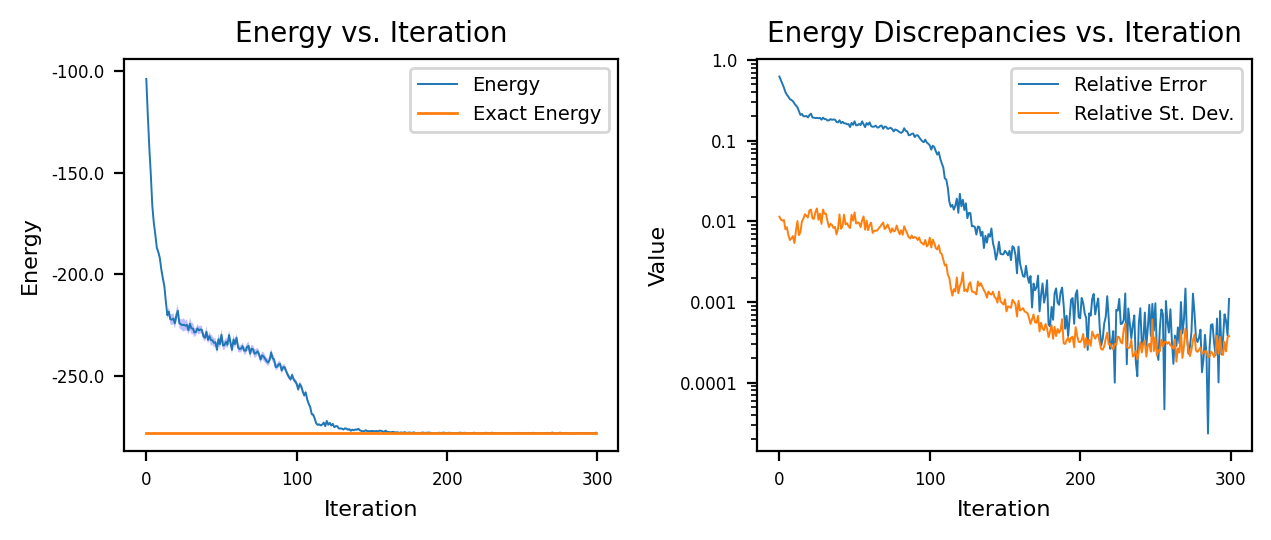

In [6]:
# Plots energy vs iteration
start = 0
end = n_iters
myNQFS.plot_energy(Es, E_stds, E_exact, start, end)

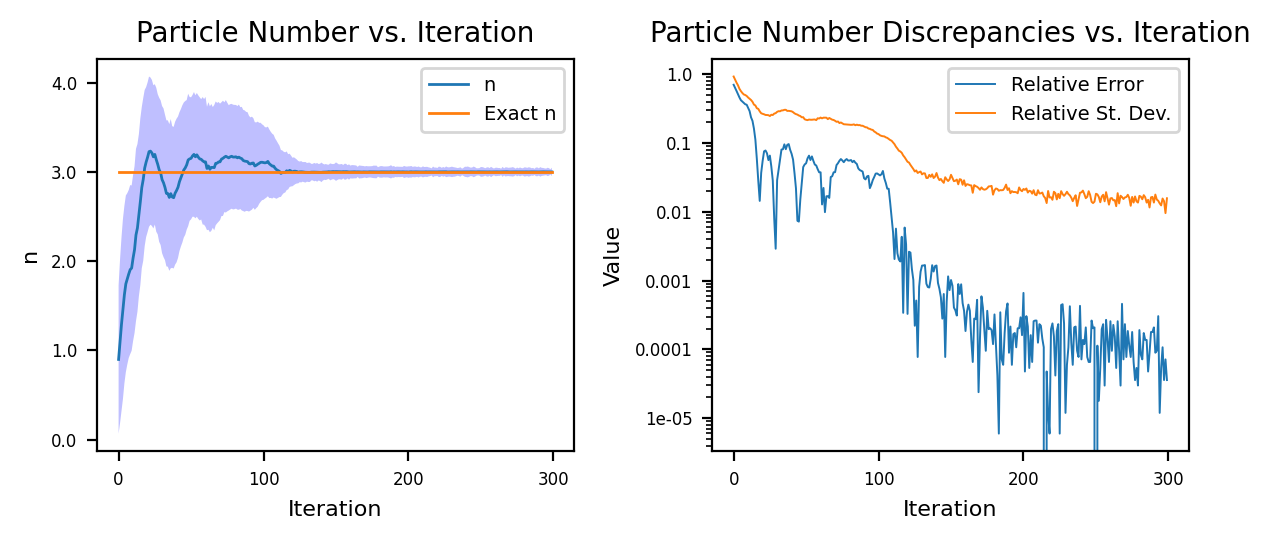

In [10]:
# Plots particle number vs iteration
start = 0
end = n_iters
myNQFS.plot_n(n_means, n_stds, n_exact, start, end)

In [8]:
# Estimate energy and particle number, uses repeated sampling to decrease variance

# MCMC parameters
n_samples = 1000                  # Number of samples per MCMC chain
n_chains = 100                    # Number of independent MCMC chains
p_pm = 0.05                       # Probability of increasing/decreasing particle number in confiuration proposal
n_0 =  round(n_means[-1].item())  # Initial particle number of each MCMC chain
N_reps = 5                        # Number of repetitions over which estimates are computed

Es_reps = np.zeros(N_reps)
E_stds_reps = np.zeros(N_reps)

# Use repeated sampling to decrease variance of estimates, estimates energy and 
# particle number over N_Reps repetitions
for j in range(N_reps):
  print('Repetition: ' + str(j+1) + '/' + str(N_reps))

  # Generate MCMC samples
  x_sorted, n, chain_idx_sorted = \
    myNQFS.GenerateMCMCSamples_FockSpace(n_samples, n_chains, p_pm, n_0, 
                                         GPU_device, m, g)
  # Concatenates particle numbers 
  if j == 0:
    n_total = n[None,:] 
  else:
    n_total = torch.cat((n_total, n[None,:]), dim=0)

  # Estimates energy, concatenates results  
  E, E_std = myNQFS.Energy_Estimate(x_sorted, chain_idx_sorted, n_chains, 
                                    GPU_device, m, mu, V, g)

  Es_reps[j-1] = E.detach().clone()
  E_stds_reps[j-1] = E_std.detach().clone()
    

# Computes final mean and standard deviation
E_mean_final = np.mean(Es_reps)
E_std_final = (np.mean(E_stds_reps**2)/N_reps)**(0.5)

n_total = n_total.cpu().numpy().astype(float)
n_mean_final = np.mean(n_total)
n_std_final = np.std(n_total)

print('\n')
print("Energy: " + str(E_mean_final) + " +- " + str(E_std_final))
print("Number of particles: " + str(n_mean_final) + " +- " + str(n_std_final))

Repetition: 1/5
Repetition: 2/5
Repetition: 3/5
Repetition: 4/5
Repetition: 5/5


Energy: -278.1347229003906 +- 0.027178133043011185
Number of particles: 3.000834285714286 +- 0.04578697221360893


In [9]:
# Estimate energy densities

# MCMC parameters
n_samples = 1000                  # Number of samples per MCMC chain
n_chains = 100                    # Number of independent MCMC chains
p_pm = 0.05                       # Probability of increasing/decreasing particle number in configuration proposal
n_0 = round(n_means[-1].item())   # Initial particle number of each MCMC chain

# Energy density parameters
N_pts = 40          # Number of points at which the number density is estimated over [0,L]
N_int = 40          # Number of integration points used to compute the numerical integral in local number density calculation
batch_size = 500    # Size of batches over which the local number density is estimated
N_reps = 3          # Number of repetitions over which estimates are computed

num_densities = np.zeros(N_pts)
num_densities_var = np.zeros(N_pts)
KE_densities = np.zeros(N_pts)
KE_densities_var = np.zeros(N_pts)

# Use repeated sampling to decrease variance of estimates, estimates energy 
# density over N_Reps repetitions
for j in range(N_reps):
  print('\n \n' + 'Repetition: ' + str(j+1) +'/' + str(N_reps))
  # Generate MCMC samples
  x_sorted, n, chain_idx_sorted = \
    myNQFS.GenerateMCMCSamples_FockSpace(n_samples, n_chains, p_pm, n_0, 
                                         GPU_device, m, g)
    
  # Evaluate energy densities
  num_densities_tmp, num_densities_std_tmp, KE_densities_tmp, KE_densities_std_tmp = \
    myNQFS.Number_KE_density_function(N_pts, x_sorted, chain_idx_sorted, n_chains, 
                                      GPU_device, m, g, N_int, batch_size)

  num_densities += num_densities_tmp
  num_densities_var = num_densities_std_tmp**2
  KE_densities += KE_densities_tmp
  KE_densities_var += KE_densities_std_tmp**2

num_densities *= 1/N_reps
num_densities_std = (num_densities_var**0.5)/N_reps
KE_densities *= 1/N_reps
KE_densities_std = (KE_densities_var**0.5)/N_reps

# Evaluate exact energy densities
num_densities_exact, KE_densities_exact = \
                                      myNQFS.TG_density_function(N_pts, n_exact, L, m)  


 
Repetition: 1/3
Evaluating number density and KE density at point 1/40
Evaluating number density and KE density at point 2/40
Evaluating number density and KE density at point 3/40
Evaluating number density and KE density at point 4/40
Evaluating number density and KE density at point 5/40
Evaluating number density and KE density at point 6/40
Evaluating number density and KE density at point 7/40
Evaluating number density and KE density at point 8/40
Evaluating number density and KE density at point 9/40
Evaluating number density and KE density at point 10/40
Evaluating number density and KE density at point 11/40
Evaluating number density and KE density at point 12/40
Evaluating number density and KE density at point 13/40
Evaluating number density and KE density at point 14/40
Evaluating number density and KE density at point 15/40
Evaluating number density and KE density at point 16/40
Evaluating number density and KE density at point 17/40
Evaluating number density and KE densi

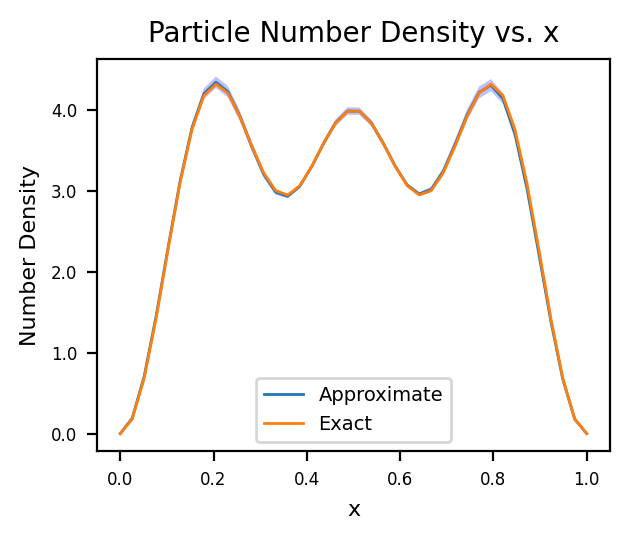

In [11]:
# Plot particle number density
myNQFS.plot_number_density(num_densities, num_densities_std, num_densities_exact) 

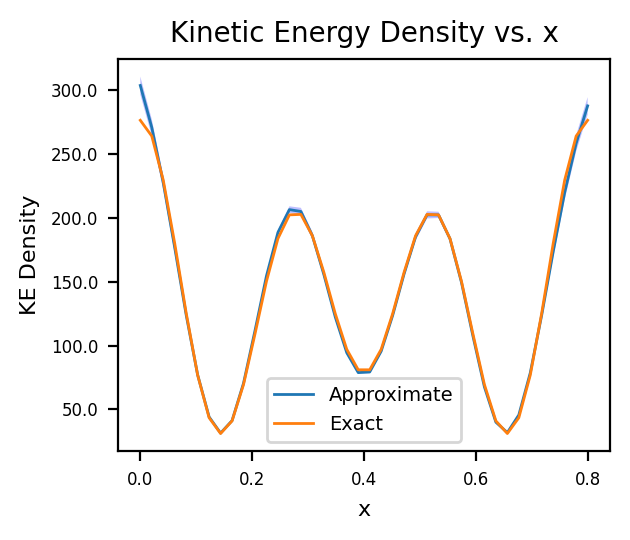

In [12]:
# Plot kinetic energy density
myNQFS.plot_KE_density(KE_densities, KE_densities_std, KE_densities_exact)                                      

In [13]:
# Estimate interaction energy density

# MCMC parameters
n_samples = 1000                 # Number of samples per MCMC chain
n_chains = 100                   # Number of independent MCMC chains
p_pm = 0.05                      # Probability of increasing/decreasing particle number in configuration proposal
n_0 = round(n_means[-1].item())  # Initial particle number of each MCMC chain

# Energy density parameters
N_pts = 40          # Number of points at which the number density is estimated over [0,L]
N_int = 20          # Number of integration points used to compute the numerical integral in local number density calculation
batch_size = 500    # Size of batches over which the local number density is estimated

# Generate MCMC samples
x_sorted, n, chain_idx_sorted = \
  myNQFS.GenerateMCMCSamples_FockSpace(n_samples, n_chains, p_pm, n_0, 
                                       GPU_device, m, g)
  
# Evaluate densities
IE_densities, IE_densities_std = \
  myNQFS.IE_density_function(N_pts, x_sorted, chain_idx_sorted, n_chains, 
                             GPU_device, m, g, N_int, batch_size)

Evaluating interaction energy density at point 1/40
Evaluating interaction energy density at point 2/40
Evaluating interaction energy density at point 3/40
Evaluating interaction energy density at point 4/40
Evaluating interaction energy density at point 5/40
Evaluating interaction energy density at point 6/40
Evaluating interaction energy density at point 7/40
Evaluating interaction energy density at point 8/40
Evaluating interaction energy density at point 9/40
Evaluating interaction energy density at point 10/40
Evaluating interaction energy density at point 11/40
Evaluating interaction energy density at point 12/40
Evaluating interaction energy density at point 13/40
Evaluating interaction energy density at point 14/40
Evaluating interaction energy density at point 15/40
Evaluating interaction energy density at point 16/40
Evaluating interaction energy density at point 17/40
Evaluating interaction energy density at point 18/40
Evaluating interaction energy density at point 19/40
Ev

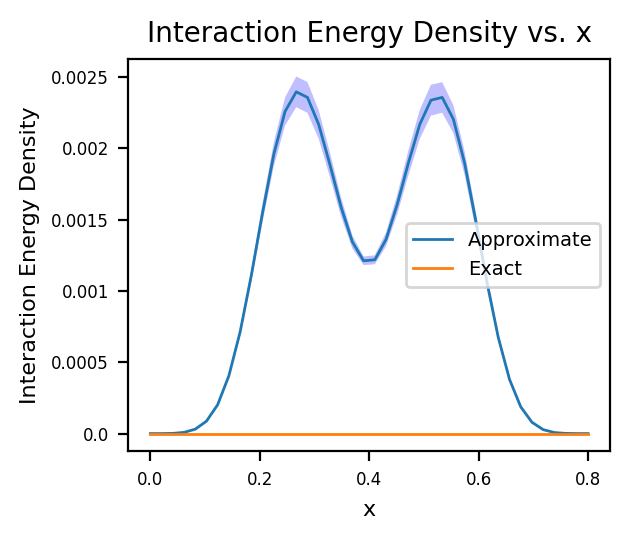

In [14]:
# Plot interaction energy density
myNQFS.plot_IE_density(IE_densities, IE_densities_std)                                      

In [15]:
# Compute total energy density
E_densities = KE_densities - mu*num_densities + IE_densities
E_densities_std = (KE_densities_std**2 + mu**2*num_densities_std**2 + IE_densities_std**2)**0.5
E_densities_exact = KE_densities_exact - mu*num_densities_exact

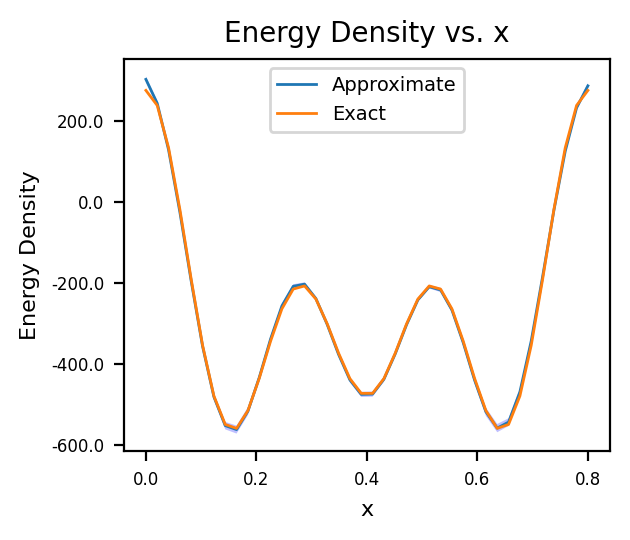

In [16]:
# Plot total energy density
myNQFS.plot_E_density(E_densities, E_densities_std, E_densities_exact)   